# Plotting results with UniMOF Model for WS24

This notebook generates plots for evaluating model training and evaluation performance.

You must have run the relevant training and inference code prior.

In [8]:
import pickle
import torch
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import f1_score


In [9]:
def plot_training_validation_loss(model_path_name):
    """
    Plots the training and validation loss over epochs from a Unicore log file.
    Adjusted for readability in research papers with increased font sizes and thicker lines.

    Parameters:
        log_file_path (str): Path to the .log file containing training and validation metrics.
    """
    # Extract metrics from the log file
    def extract_training_metrics(model_path_name):
        """
        Extracts training, validation, and test metrics from a Unicore log file.

        Parameters:
            log_file_path (str): Path to the .log file.

        Returns:
            List[Dict[str, float]]: A list of dictionaries, each containing metrics from one epoch.
        """
        pattern = re.compile(
            r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2} \| INFO \| (?P<type>train|valid|test) \| epoch (?P<epoch>\d+) \|.*?loss (?P<loss>[\d.]+)"
        )

        metrics = []
        with open(f"./logs{model_path_name}/save_finetune_WS24{model_path_name}.log", "r", encoding="utf-16") as f:
            for line in f:
                match = pattern.search(line)
                if match:
                    entry = {
                        "type": match.group("type"),
                        "epoch": int(match.group("epoch")),
                        "loss": float(match.group("loss")),
                    }
                    metrics.append(entry)
        return metrics

    # Load metrics
    metrics = extract_training_metrics(model_path_name)

    # Separate the data by type
    train_data = [entry for entry in metrics if entry['type'] == 'train']
    valid_data = [entry for entry in metrics if entry['type'] == 'valid']

    # Plotting the losses
    plt.figure(figsize=(10, 6))
    plt.plot(
        [entry['epoch'] for entry in train_data],
        [entry['loss'] for entry in train_data],
        label='Training Loss',
        linewidth=2,
    )
    plt.plot(
        [entry['epoch'] for entry in valid_data],
        [entry['loss'] for entry in valid_data],
        label='Validation Loss',
        linewidth=2,
    )
    plt.xlabel('Epoch', fontsize=16, weight='bold')
    plt.ylabel('Loss', fontsize=16, weight='bold')
    plt.title('Training and Validation Loss Over Epochs', fontsize=18, weight='bold')
    plt.legend(fontsize=14)
    plt.grid(True, linewidth=1.5)
    plt.tick_params(axis='both', labelsize=14, width=2)
    for spine in plt.gca().spines.values():
        spine.set_linewidth(2)  # Thicker plot borders
    plt.tight_layout()
    plt.show()


In [10]:
def plot_evaluation_results(model_path_name, num_classes, class_labels):
    """
    For a given model_path_name, loads evaluation logs, processes outputs,
    and plots the confusion matrix, combined 2x2 confusion matrix, and ROC AUC curves.
    Adjusted for readability in research papers with increased font sizes, thicker lines,
    larger numbers in the confusion matrices, and square matrices with a black border.

    Args:
        model_path_name (str): The model path name to load evaluation logs.
        num_classes (int): Number of classes in the dataset.
        class_labels (list): List of class labels for the confusion matrix.
    """
    # Load evaluation logs
    with open(f'./evaluation{model_path_name}/logs{model_path_name}_valid.out.pkl', 'rb') as file:
        valid_logs = pickle.load(file)

    # Process outputs
    def process_outputs(logging_outputs, num_classes):
        all_preds = []
        all_targets = []
        all_logits = []

        for log in logging_outputs:
            all_preds.append(log["predict"].detach().cpu())
            all_targets.append(log["target"].detach().cpu())
            all_logits.append(log["logits"].detach().cpu())

        y_pred = torch.cat(all_preds).numpy()
        y_true = torch.cat(all_targets).numpy()
        y_logits = torch.cat(all_logits).numpy()

        return y_true, y_pred, y_logits

    y_true, y_pred, y_logits = process_outputs(valid_logs, num_classes)

    # Create a single figure for all plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot original confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels, ax=axes[0],
                cbar=False, annot_kws={"size": 16}, square=True)  # Ensure square matrix
    axes[0].set_xlabel('Predicted', fontsize=18, weight='bold')
    axes[0].set_ylabel('True', fontsize=18, weight='bold')
    axes[0].set_title('Confusion Matrix', fontsize=20, weight='bold')
    axes[0].tick_params(axis='both', labelsize=14, width=2)
    for spine in axes[0].spines.values():
        spine.set_linewidth(2)  # Thicker plot borders
    # Add black border
    axes[0].add_patch(plt.Rectangle((0, 0), cm.shape[1], cm.shape[0], fill=False, edgecolor='black', lw=3))

    # Compute F1-score for each class and macro-average
    f1_per_class = f1_score(y_true, y_pred, average=None, labels=range(num_classes))
    f1_macro = f1_score(y_true, y_pred, average="macro")

    # Display F1-scores above the confusion matrix
    f1_text = "\n".join([f"Class {class_labels[i]}: {f1:.2f}" for i, f1 in enumerate(f1_per_class)])
    f1_text += f"\nMacro F1: {f1_macro:.2f}"
    axes[0].text(0.5, -0.3, f1_text, ha='center', va='center', transform=axes[0].transAxes, fontsize=14)

    # Combine classes for 2x2 confusion matrix
    combined_y_true = np.where(np.isin(y_true, [1, 2]), 0, 1)  # Combine classes 1 & 2 -> 0, 3 & 4 -> 1
    combined_y_pred = np.where(np.isin(y_pred, [1, 2]), 0, 1)
    combined_cm = confusion_matrix(combined_y_true, combined_y_pred)

    combined_class_labels = [f"{class_labels[0]}+{class_labels[1]}", f"{class_labels[2]}+{class_labels[3]}"]
    sns.heatmap(combined_cm, annot=True, fmt='d', cmap='Oranges',
                xticklabels=combined_class_labels, yticklabels=combined_class_labels, ax=axes[1],
                cbar=False, annot_kws={"size": 16}, square=True)  # Ensure square matrix
    axes[1].set_xlabel('Predicted', fontsize=18, weight='bold')
    axes[1].set_ylabel('True', fontsize=18, weight='bold')
    axes[1].set_title('2x2 Combined Confusion Matrix', fontsize=20, weight='bold')
    axes[1].tick_params(axis='both', labelsize=14, width=2)
    for spine in axes[1].spines.values():
        spine.set_linewidth(2)  # Thicker plot borders
    # Add black border
    axes[1].add_patch(plt.Rectangle((0, 0), combined_cm.shape[1], combined_cm.shape[0], fill=False, edgecolor='black', lw=3))

    # Compute and display F1-score for 2x2 confusion matrix
    f1_combined = f1_score(combined_y_true, combined_y_pred, average="macro")
    axes[1].text(0.5, -0.3, f"F1 Score: {f1_combined:.2f}", ha='center', va='center', transform=axes[1].transAxes, fontsize=14)

    # Plot ROC AUC curves
    y_true_bin = label_binarize(y_true, classes=range(1, num_classes + 1))
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_logits[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        axes[2].plot(fpr[i], tpr[i], label=f"Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})", linewidth=2)

    axes[2].plot([0, 1], [0, 1], 'k--', linewidth=2)
    axes[2].set_xlabel("False Positive Rate", fontsize=18, weight='bold')
    axes[2].set_ylabel("True Positive Rate", fontsize=18, weight='bold')
    axes[2].set_title("ROC Curve", fontsize=20, weight='bold')
    axes[2].legend(fontsize=14)
    axes[2].tick_params(axis='both', labelsize=14, width=2)
    axes[2].grid(True, linewidth=1.5)
    for spine in axes[2].spines.values():
        spine.set_linewidth(2)  # Thicker plot borders

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_combined_results(model_path_names, model_titles, num_classes, class_labels, valid_subset):
    """
    Combines training/validation loss, confusion matrices, and ROC-AUC curves for multiple models
    into a single figure with subplots. Adds row and column labels for clarity and includes F1 scores.

    Args:
        model_path_names (list): List of model path names to process.
        num_classes (int): Number of classes in the dataset.
        class_labels (list): List of class labels for the confusion matrix.
    """
    num_models = len(model_path_names)
    fig, axes = plt.subplots(4, num_models, figsize=(10 * num_models, 40))  # Larger figure size for readability

    # Add row labels
    row_labels = [
        "Training and\nValidation Loss",
        "Confusion Matrix",
        "2x2 Combined\nConfusion Matrix",
        "ROC Curve",
    ]
    for row, label in enumerate(row_labels):
        fig.text(0.04, 0.85 - (row * 0.22), label, fontsize=40, weight='bold', ha='center', va='center', rotation=90)

    # Add column labels
    for col, model_title in enumerate(model_titles):
        axes[0, col].set_title(model_title, fontsize=40, weight='bold', pad=30)

    for col, model_path_name in enumerate(model_path_names):
        # Row 1: Training and Validation Loss
        def extract_training_metrics(model_path_name):
            pattern = re.compile(
                r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2} \| INFO \| (?P<type>train|valid|test) \| epoch (?P<epoch>\d+) \|.*?loss (?P<loss>[\d.]+)"
            )
            metrics = []
            with open(f"./logs{model_path_name}/save_finetune_WS24{model_path_name}.log", "r", encoding="utf-16") as f:
                for line in f:
                    match = pattern.search(line)
                    if match:
                        entry = {
                            "type": match.group("type"),
                            "epoch": int(match.group("epoch")),
                            "loss": float(match.group("loss")),
                        }
                        metrics.append(entry)
            return metrics

        metrics = extract_training_metrics(model_path_name)
        train_data = [entry for entry in metrics if entry['type'] == 'train']
        valid_data = [entry for entry in metrics if entry['type'] == 'valid']

        # Plot training and validation loss
        axes[0, col].plot(
            [entry['epoch'] for entry in train_data],
            [entry['loss'] for entry in train_data],
            label='Training Loss',
            linewidth=4,
        )
        axes[0, col].plot(
            [entry['epoch'] for entry in valid_data],
            [entry['loss'] for entry in valid_data],
            label='Validation Loss',
            linewidth=4,
        )
        axes[0, col].set_xlabel('Epoch', fontsize=36, weight='bold')
        axes[0, col].set_ylabel('Loss', fontsize=36, weight='bold')
        axes[0, col].legend(fontsize=28)
        axes[0, col].tick_params(axis='both', labelsize=28, width=3)

        # Align y-axes across all columns
        all_losses = [entry['loss'] for entry in train_data] + [entry['loss'] for entry in valid_data]
        axes[0, col].set_ylim([min(all_losses) * 0.9, max(all_losses) * 1.1])

        # Row 2-4: Evaluation Results
        with open(f'./evaluation{model_path_name}/logs{model_path_name}_{valid_subset}.out.pkl', 'rb') as file:
            valid_logs = pickle.load(file)

        def process_outputs(logging_outputs, num_classes):
            all_preds = []
            all_targets = []
            all_logits = []

            for log in logging_outputs:
                all_preds.append(log["predict"].detach().cpu())
                all_targets.append(log["target"].detach().cpu())
                all_logits.append(log["logits"].detach().cpu())

            y_pred = torch.cat(all_preds).numpy()
            y_true = torch.cat(all_targets).numpy()
            y_logits = torch.cat(all_logits).numpy()

            return y_true, y_pred, y_logits

        y_true, y_pred, y_logits = process_outputs(valid_logs, num_classes)

        # Row 2: Original Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_labels, yticklabels=class_labels, ax=axes[1, col],
                    cbar=False, annot_kws={"size": 28}, square=True)
        axes[1, col].set_xlabel('Predicted', fontsize=36, weight='bold')
        axes[1, col].set_ylabel('True', fontsize=36, weight='bold')
        axes[1, col].tick_params(axis='both', labelsize=28, width=3)

        # Compute F1 scores for the original confusion matrix
        f1_per_class = f1_score(y_true, y_pred, average=None, labels=range(1,num_classes+1))
        f1_macro = f1_score(y_true, y_pred, average="macro",labels=range(1, num_classes + 1))
        f1_text = "\n".join([f"Class {class_labels[i]}: {f1:.2f}" for i, f1 in enumerate(f1_per_class)])
        f1_text += f"\nMacro F1: {f1_macro:.2f}"
        axes[1, col].text(0.5, -0.5, f1_text, ha='center', va='center', transform=axes[1, col].transAxes, fontsize=28)

        # Row 3: 2x2 Combined Confusion Matrix
        combined_y_true = np.where(np.isin(y_true, [1, 2]), 0, 1)
        combined_y_pred = np.where(np.isin(y_pred, [1, 2]), 0, 1)
        combined_cm = confusion_matrix(combined_y_true, combined_y_pred)

        combined_class_labels = [f"{class_labels[0]}+{class_labels[1]}", f"{class_labels[2]}+{class_labels[3]}"]
        sns.heatmap(combined_cm, annot=True, fmt='d', cmap='Oranges',
                    xticklabels=combined_class_labels, yticklabels=combined_class_labels, ax=axes[2, col],
                    cbar=False, annot_kws={"size": 28}, square=True)
        axes[2, col].set_xlabel('Predicted', fontsize=36, weight='bold')
        axes[2, col].set_ylabel('True', fontsize=36, weight='bold')
        axes[2, col].tick_params(axis='both', labelsize=28, width=3)

        # Compute F1 scores for the combined confusion matrix
        f1_combined = f1_score(combined_y_true, combined_y_pred, average="macro", labels=[0,1])
        axes[2, col].text(0.5, -0.5, f"F1 Score: {f1_combined:.2f}", ha='center', va='center', transform=axes[2, col].transAxes, fontsize=28)

        # Row 4: ROC-AUC Curves
        y_true_bin = label_binarize(y_true, classes=range(1, num_classes + 1))
        fpr, tpr, roc_auc = {}, {}, {}

        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_logits[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            axes[3, col].plot(fpr[i], tpr[i], label=f"Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})", linewidth=4)

        axes[3, col].plot([0, 1], [0, 1], 'k--', linewidth=3)
        axes[3, col].set_xlabel("False Positive Rate", fontsize=36, weight='bold')
        axes[3, col].set_ylabel("True Positive Rate", fontsize=36, weight='bold')
        axes[3, col].legend(fontsize=28)
        axes[3, col].tick_params(axis='both', labelsize=28, width=3)

    # Adjust spacing for row and column labels
    fig.subplots_adjust(left=0.1, top=0.9, wspace=0.3, hspace=0.8)
    plt.show()


In [14]:
model_path_names = [
    '_weighted',
    '_partial_freeze_weighted',
    '_mostly_freeze_weighted',
    '_freeze_weighted',
]

model_titles =[
    'Fully Parametrizable',
    'Partially Frozen',
    'Mostly Frozen',
    'Fully Frozen'
]

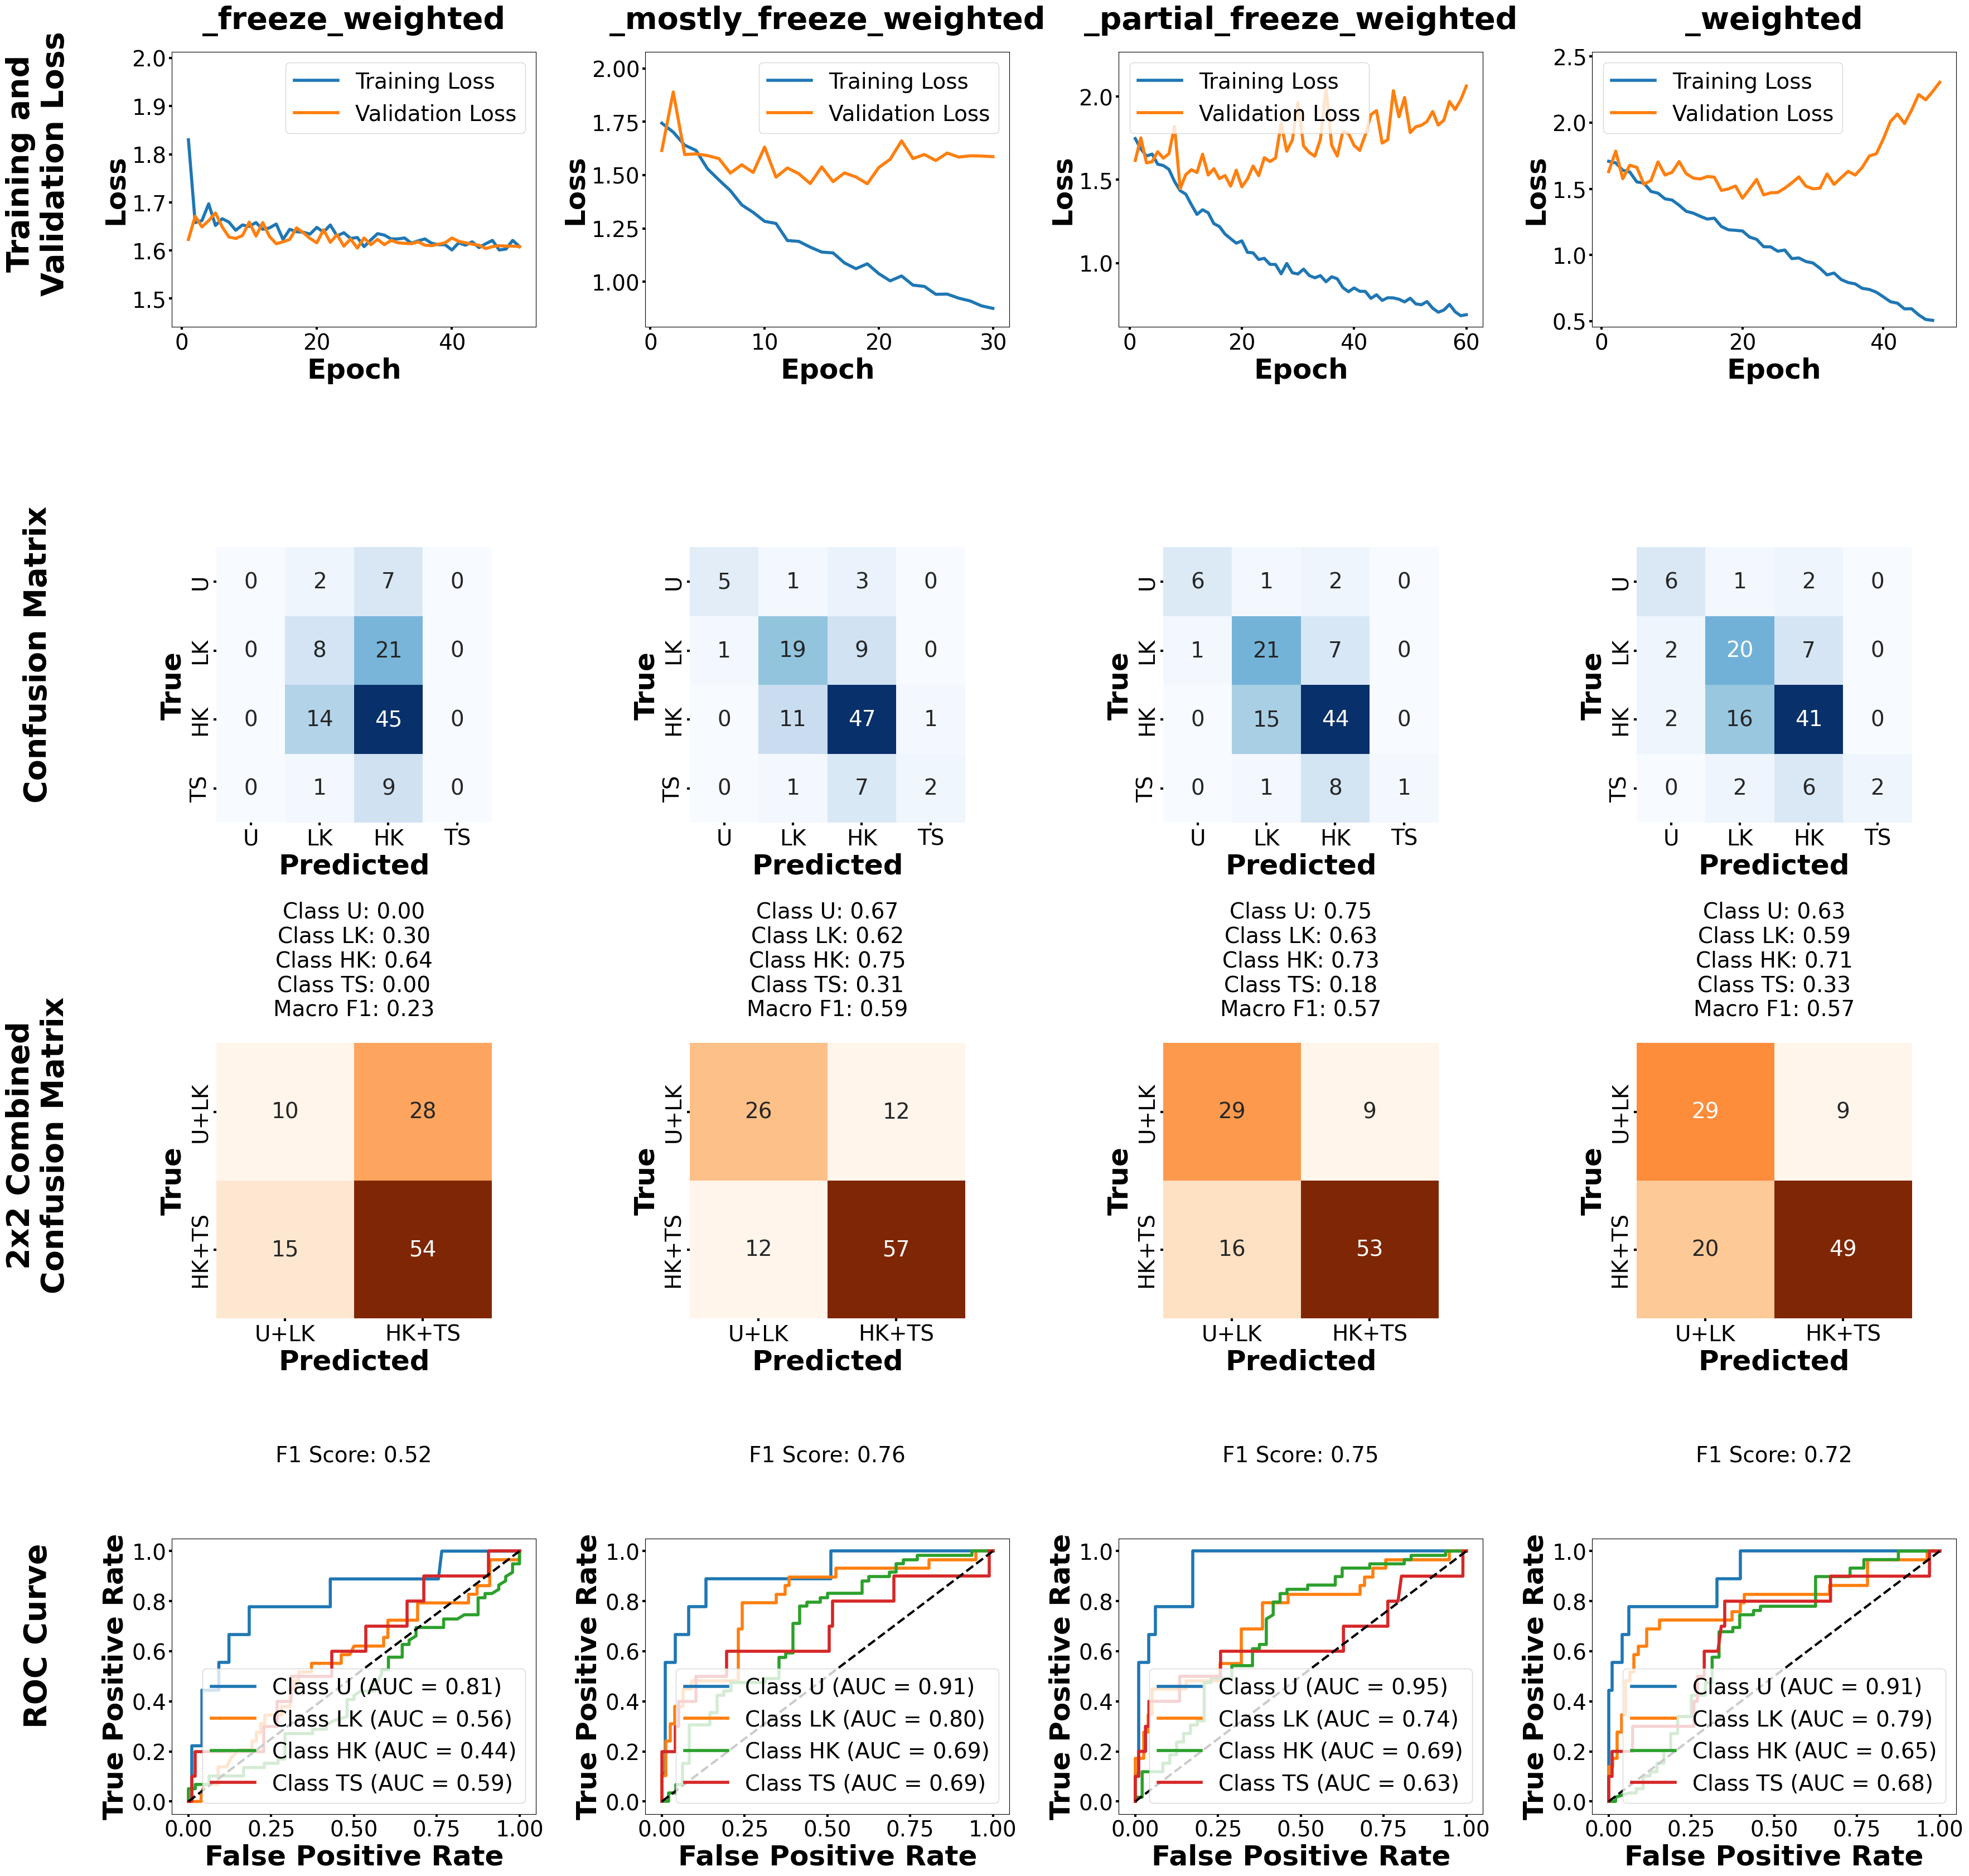

In [ ]:
num_classes = 4 
class_labels = ["U", "LK", "HK", "TS"]  # actual class labels if using 1-based classes

'''
for model_path_name in model_path_names:
    print(f"\n=== Training and Validation Loss for Model Path: WS24-UniMOF{model_path_name} ===")
    plot_training_validation_loss(model_path_name)
    print(f"\n=== Evaluation for Model Path: WS24-UniMOF{model_path_name} ===")
    plot_evaluation_results(model_path_name, num_classes, class_labels)
'''

plot_combined_results(model_path_names, model_titles, num_classes, class_labels, 'test')
